In [1]:
# if hit plotting library issues, try resetting LD path for julia
# can set in ~/.local/share/jupyter/kernels/
haskey(ENV, "LD_LIBRARY_PATH") && @assert ENV["LD_LIBRARY_PATH"] == ""
import Pkg
pkgs = [
    "Revise",
    "FASTX",
    "BioSequences",
    "Kmers",
    "Graphs",
    "MetaGraphs",
    "SparseArrays",
    "ProgressMeter",
    "Distributions",
    "HiddenMarkovModels",
    "BioAlignments",
    "StatsBase",
    "Random",
    "StatsPlots",
    "Statistics",
    # "GraphMakie",
    "IterTools",
    "Primes",
    "OnlineStats",
    "IteratorSampling",
    "HypothesisTests",
    "Clustering",
    "Distances",
    "BioAlignments",
    "Statistics",
    "Primes"
]
# Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end
# Pkg.develop(path="/global/cfs/projectdirs/m4269/cjprybol/Mycelia")
# Pkg.develop(path="../../..")
import Mycelia

┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ /global/cfs/cdirs/m4269/cjprybol/Mycelia/Manifest.toml:0
[ Info: Precompiling Mycelia [453d265d-8292-4a7b-a57c-dce3f9ae6acd]
[ Info: Skipping precompilation since __precompile__(false). Importing Mycelia [453d265d-8292-4a7b-a57c-dce3f9ae6acd].


In [2]:
PROJECT_BASEDIR = dirname(pwd())
data_dir = joinpath(PROJECT_BASEDIR, "data")
genome_dir = mkpath(joinpath(data_dir, "genomes"))

"/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/variant-calling-benchmarking/data/genomes"

In [3]:
working_dir = joinpath(data_dir, "test")
mkpath(working_dir)

"/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/variant-calling-benchmarking/data/test"

In [4]:
# short_read_sets = unique(map(x -> match(r"^(.+\.\d+x)\.", x).captures[1], filter(x -> occursin(r"\.fna\.art", x) && occursin(r"\.fq\.gz", x) && !occursin("trimming_report", x) && !occursin("_val_", x), sort(readdir(genome_dir, join=true), by=x->filesize(x)))))
# # forward = short_read_set * ".1_val_1.fq.gz"
# # reverse = short_read_set * ".2_val_2.fq.gz"

In [5]:
long_read_fastqs = sort(filter(x -> occursin(r"\.filtlong\.fq\.gz$", x), readdir(genome_dir, join=true)), by=x->filesize(x))
fastq = long_read_fastqs[1]

"/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/variant-calling-benchmarking/data/genomes/fF3EHHs.fna.normalized.vcf.fna.badread.10x.filtlong.fq.gz"

In [6]:
# reference_fasta = replace(fastq, r"\.badread.*" => "")

In [7]:
function find_resampling_stretches(;record_kmer_solidity, solid_branching_kmer_indices)
    indices = findall(.!record_kmer_solidity)  # Find the indices of false values
    if isempty(indices)
        return UnitRange{Int64}[]
    end
    
    diffs = diff(indices)  # Calculate the differences between consecutive indices
    # @show diffs
    range_starts = [indices[1]]  # Start with the first false index
    range_ends = Int[]
    
    for (i, d) in enumerate(diffs)
        if d > 1
            push!(range_ends, indices[i])
            push!(range_starts, indices[i+1])
        end
    end
    
    push!(range_ends, indices[end])  # Add the last false index as a range end
    
    low_quality_runs = [(start, stop) for (start, stop) in zip(range_starts, range_ends)]
    
    resampling_stretches = UnitRange{Int64}[]
    
    for low_quality_run in low_quality_runs
        unders = filter(solid_branching_kmer -> solid_branching_kmer < first(low_quality_run), solid_branching_kmer_indices)
        overs = filter(solid_branching_kmer -> solid_branching_kmer > last(low_quality_run), solid_branching_kmer_indices)
        if isempty(overs) || isempty(unders)
            continue
        else
            nearest_under = maximum(unders)
            nearest_over = minimum(overs)
            push!(resampling_stretches, nearest_under:nearest_over)
        end
    end
    if !allunique(resampling_stretches)
        resampling_stretches = unique!(resampling_stretches)
    end
    return resampling_stretches
end

find_resampling_stretches (generic function with 1 method)

In [8]:
function fastq_record(;identifier, sequence, quality_scores)
    # Fastx wont parse anything higher than 93
    quality_scores = min.(quality_scores, 93)
    record_string = join(["@" * identifier, sequence, "+", join([Char(x+33) for x in quality_scores])], "\n")
    return FASTX.parse(FASTX.FASTQRecord, record_string)
end

fastq_record (generic function with 1 method)

In [9]:
function process_fastq_record(;record, kmer_graph, yen_k_shortest_paths_and_weights, yen_k=7)
    ordered_kmers = MetaGraphs.get_prop(kmer_graph, :ordered_kmers)
    likely_valid_kmers = Set(ordered_kmers[MetaGraphs.get_prop(kmer_graph, :likely_valid_kmer_indices)])
    kmer_to_index_map = MetaGraphs.get_prop(kmer_graph, :kmer_indices)
    branching_nodes_set = MetaGraphs.get_prop(kmer_graph, :branching_nodes)
    assembly_k = MetaGraphs.get_prop(kmer_graph, :assembly_k)
    transition_likelihoods = MetaGraphs.get_prop(kmer_graph, :transition_likelihoods)
    kmer_mean_quality = MetaGraphs.get_prop(kmer_graph, :kmer_mean_quality)
    kmer_total_quality = MetaGraphs.get_prop(kmer_graph, :kmer_total_quality)
    
    new_record_identifier = FASTX.identifier(record) * ".k$(assembly_k)"
    record_sequence = BioSequences.LongDNA{4}(FASTX.sequence(record))

    kmer_type = Kmers.DNAKmer{assembly_k}
    record_kmers = last.(collect(Kmers.EveryKmer{kmer_type}(record_sequence)))
    record_quality_scores = collect(FASTX.quality_scores(record))
    record_kmer_quality_scores = [record_quality_scores[i:i+assembly_k-1] for i in 1:length(record_quality_scores)-assembly_k+1]
    
    record_kmer_solidity = map(kmer -> kmer in likely_valid_kmers, record_kmers)
    record_branching_kmers = [kmer_to_index_map[kmer] in branching_nodes_set for kmer in record_kmers]
    record_solid_branching_kmers = record_kmer_solidity .& record_branching_kmers
    
    # trim beginning of fastq
    initial_solid_kmer = findfirst(record_kmer_solidity)
    if isnothing(initial_solid_kmer)
        return record
    elseif initial_solid_kmer > 1
        record_kmers = record_kmers[initial_solid_kmer:end]
        record_kmer_quality_scores = record_kmer_quality_scores[initial_solid_kmer:end]
        record_kmer_solidity = map(kmer -> kmer in likely_valid_kmers, record_kmers)
        record_branching_kmers = [kmer_to_index_map[kmer] in branching_nodes_set for kmer in record_kmers]
        record_solid_branching_kmers = record_kmer_solidity .& record_branching_kmers
    end
    initial_solid_kmer = 1
    
    # trim end of fastq
    last_solid_kmer = findlast(record_kmer_solidity)
    if last_solid_kmer != length(record_kmer_solidity)
        record_kmers = record_kmers[1:last_solid_kmer]
        record_kmer_quality_scores = record_kmer_quality_scores[1:last_solid_kmer]
        record_kmer_solidity = map(kmer -> kmer in likely_valid_kmers, record_kmers)
        record_branching_kmers = [kmer_to_index_map[kmer] in branching_nodes_set for kmer in record_kmers]
        record_solid_branching_kmers = record_kmer_solidity .& record_branching_kmers
    end
    
    # identify low quality runs and the solid branchpoints we will use for resampling
    solid_branching_kmer_indices = findall(record_solid_branching_kmers)
    resampling_stretches = find_resampling_stretches(;record_kmer_solidity, solid_branching_kmer_indices)

    # nothing to do
    if isempty(resampling_stretches)
        return record
    end
    trusted_range = 1:max(first(first(resampling_stretches))-1, 1)
    
    new_record_kmers = record_kmers[trusted_range]
    new_record_kmer_qualities = record_kmer_quality_scores[trusted_range]
    
    
    for (i, resampling_stretch) in enumerate(resampling_stretches)
        starting_solid_kmer = record_kmers[first(resampling_stretch)]
        ending_solid_kmer = record_kmers[last(resampling_stretch)]
        
        current_quality_scores = record_quality_scores[resampling_stretch]
        u = kmer_to_index_map[starting_solid_kmer]
        v = kmer_to_index_map[ending_solid_kmer]
        if !haskey(yen_k_shortest_paths_and_weights, u => v)
            yen_k_result = Graphs.yen_k_shortest_paths(kmer_graph, u, v, Graphs.weights(kmer_graph), yen_k)
            yen_k_shortest_paths_and_weights[u => v] = Vector{Pair{Vector{Int}, Float64}}()
            for path in yen_k_result.paths
                path_weight = Statistics.mean([kmer_total_quality[ordered_kmers[node]] for node in path])
                path_transition_likelihoods = 1.0
                for (a, b) in zip(path[1:end-1], path[2:end])
                    path_transition_likelihoods *= transition_likelihoods[a, b]
                end
                joint_weight = path_weight * path_transition_likelihoods
                push!(yen_k_shortest_paths_and_weights[u => v], path => joint_weight)
            end
        end
        yen_k_path_weights = yen_k_shortest_paths_and_weights[u => v]      
        if length(yen_k_path_weights) > 1
            current_distance = length(resampling_stretch)
            initial_weights = last.(yen_k_path_weights)
            path_lengths = length.(first.(yen_k_path_weights))
            deltas = map(l -> abs(l-current_distance), path_lengths)
            adjusted_weights = initial_weights .* map(d -> exp(-d * log(2)), deltas)
            # make it more severe?
            # adjusted_weights = adjusted_weights.^2
            
            # and a bonus for usually being correct
            
            selected_path_index = StatsBase.sample(StatsBase.weights(adjusted_weights))
            selected_path, selected_path_weights = yen_k_path_weights[selected_path_index]
            selected_path_kmers = [ordered_kmers[kmer_index] for kmer_index in selected_path]
            
            if last(new_record_kmers) == first(selected_path_kmers)
                selected_path_kmers = selected_path_kmers[2:end]
            end
            append!(new_record_kmers, selected_path_kmers)
            selected_kmer_qualities = [Int8.(min.(typemax(Int8), floor.(kmer_mean_quality[kmer]))) for kmer in selected_path_kmers]
            append!(new_record_kmer_qualities, selected_kmer_qualities)
        else
            selected_path_kmers = record_kmers[resampling_stretch]
            if last(new_record_kmers) == first(selected_path_kmers)
                selected_path_kmers = selected_path_kmers[2:end]
            end
            append!(new_record_kmers, selected_path_kmers)
            selected_kmer_qualities = [Int8.(min.(typemax(Int8), floor.(kmer_mean_quality[kmer]))) for kmer in selected_path_kmers]
            append!(new_record_kmer_qualities, selected_kmer_qualities)
        end
        if i < length(resampling_stretches) # append high quality gap
            next_solid_start = last(resampling_stretch)+1
            next_resampling_stretch = resampling_stretches[i+1]
            next_solid_stop = first(next_resampling_stretch)-1
            if !isempty(next_solid_start:next_solid_stop)
                selected_path_kmers = record_kmers[next_solid_start:next_solid_stop]
                append!(new_record_kmers, selected_path_kmers)
                selected_kmer_qualities = record_kmer_quality_scores[next_solid_start:next_solid_stop]
                append!(new_record_kmer_qualities, selected_kmer_qualities)
            end
        else # append remainder of sequence
            @assert i == length(resampling_stretches)
            next_solid_start = last(resampling_stretch)+1
            if next_solid_start < length(record_kmers)
                selected_path_kmers = record_kmers[next_solid_start:end]
                append!(new_record_kmers, selected_path_kmers)
                selected_kmer_qualities = record_kmer_quality_scores[next_solid_start:end]
                append!(new_record_kmer_qualities, selected_kmer_qualities)
            end
        end
    end
    
    for (a, b) in zip(new_record_kmers[1:end-1], new_record_kmers[2:end])
        @assert a != b
    end
    new_record_sequence = Mycelia.kmer_path_to_sequence(new_record_kmers)
    new_record_quality_scores = new_record_kmer_qualities[1]
    for new_record_kmer_quality in new_record_kmer_qualities[2:end]
        push!(new_record_quality_scores, last(new_record_kmer_quality))
    end
    new_record = fastq_record(identifier=new_record_identifier, sequence=new_record_sequence, quality_scores=new_record_quality_scores)
    return new_record
end

process_fastq_record (generic function with 1 method)

In [10]:
function polish_fastq(;fastq, k=1)
    kmer_graph = build_directed_kmer_graph(fastq=fastq, k=k)
    assembly_k = MetaGraphs.get_prop(kmer_graph, :assembly_k)
    @info "polishing with k = $(assembly_k)"
    revised_records = []
    yen_k_shortest_paths_and_weights = Dict{Pair{Int, Int}, Vector{Pair{Vector{Int}, Float64}}}()
    ProgressMeter.@showprogress for record in collect(Mycelia.open_fastx(fastq))
        revised_record = process_fastq_record(;record, kmer_graph, yen_k_shortest_paths_and_weights)
        push!(revised_records, revised_record)
    end
    
    fastq_out = replace(fastq, Mycelia.FASTQ_REGEX => ".k$(assembly_k).fq")
    open(fastq_out, "w") do io
        fastx_io = FASTX.FASTQ.Writer(io)
        for record in revised_records
            write(fastx_io, record)
        end
        close(fastx_io)
    end
    run(`gzip --force $(fastq_out)`)
    return (fastq = fastq_out * ".gz", k=assembly_k)
end

polish_fastq (generic function with 1 method)

In [56]:
function build_directed_kmer_graph(;fastq, k=1, plot=true)
    if k == 1
        assembly_k = Mycelia.assess_dnamer_saturation([fastq])
    else
        @assert isodd(k)
        @assert Primes.isprime(k)
        assembly_k = k
    end
    kmer_type = Kmers.DNAKmer{assembly_k}

    # initializing the graph with kmer counts
    kmer_counts = Mycelia.count_kmers(kmer_type, fastq)
    ordered_kmers = collect(keys(kmer_counts))
    total_states = length(ordered_kmers)
    graph = MetaGraphs.MetaDiGraph(total_states)
    MetaGraphs.set_prop!(graph, :assembly_k, assembly_k)
    MetaGraphs.set_prop!(graph, :kmer_counts, kmer_counts)
    MetaGraphs.set_prop!(graph, :total_states, total_states)
    MetaGraphs.set_prop!(graph, :ordered_kmers, ordered_kmers)
    kmer_indices = sort(Dict(kmer => i for (i, kmer) in enumerate(keys(kmer_counts))))
    MetaGraphs.set_prop!(graph, :kmer_indices, kmer_indices)
    canonical_kmer_counts = Mycelia.count_canonical_kmers(kmer_type, fastq)
    MetaGraphs.set_prop!(graph, :canonical_kmer_counts, canonical_kmer_counts)
    canonical_kmer_indices = sort(Dict(kmer => i for (i, kmer) in enumerate(keys(canonical_kmer_counts))))
    MetaGraphs.set_prop!(graph, :canonical_kmer_indices, canonical_kmer_indices)
    
    
    # kmer quality and likelihoods
    
    records = collect(Mycelia.open_fastx(fastq))
    read_quality_scores = [collect(FASTX.quality_scores(record)) for record in records]
    all_kmer_quality_support = Dict{kmer_type, Vector{Float64}}()
    for record in records
        record_quality_scores = collect(FASTX.quality_scores(record))
        record_quality_score_slices = [record_quality_scores[i:i+assembly_k-1] for i in 1:length(record_quality_scores)-assembly_k+1]
        sequence = BioSequences.LongDNA{2}(FASTX.sequence(record))
        for ((i, kmer), kmer_base_qualities) in zip(Kmers.EveryKmer{kmer_type}(sequence), record_quality_score_slices)
            if haskey(all_kmer_quality_support, kmer)
                all_kmer_quality_support[kmer] = all_kmer_quality_support[kmer] .+ kmer_base_qualities
            else
                all_kmer_quality_support[kmer] = kmer_base_qualities
            end
        end
    end
    
    # strand normalization shares observational quality across strands - only relevant for non-stranded DNA genome assembly
    strand_normalized_quality_support = Dict{kmer_type, Vector{Float64}}()
    for (kmer, support) in all_kmer_quality_support
        strand_normalized_quality_support[kmer] = support
        if haskey(all_kmer_quality_support, BioSequences.reverse_complement(kmer))
            strand_normalized_quality_support[kmer] .+= all_kmer_quality_support[BioSequences.reverse_complement(kmer)]
        end
    end
    strand_normalized_quality_support
    kmer_mean_quality = sort(Dict(kmer => strand_normalized_quality_support[kmer] ./ canonical_kmer_counts[BioSequences.canonical(kmer)] for kmer in ordered_kmers))
    MetaGraphs.set_prop!(graph, :kmer_mean_quality, kmer_mean_quality)
    kmer_total_quality = sort(Dict(kmer => sum(quality_values) for (kmer, quality_values) in strand_normalized_quality_support))
    MetaGraphs.set_prop!(graph, :kmer_total_quality, kmer_total_quality)
    state_likelihoods = sort(Dict(kmer => total_quality / sum(values(kmer_total_quality)) for (kmer, total_quality) in kmer_total_quality))
    MetaGraphs.set_prop!(graph, :state_likelihoods, state_likelihoods)


    # all transition likelihood calculation
    transition_likelihoods = SparseArrays.spzeros(total_states, total_states)
    for record in records
        sequence = BioSequences.LongDNA{4}(FASTX.sequence(record))
        sources = Kmers.EveryKmer{kmer_type}(sequence[1:end-1])
        destinations = Kmers.EveryKmer{kmer_type}(sequence[2:end])
        for ((source_i, source), (destination_i, destination)) in zip(sources, destinations)
            source_index = kmer_indices[source]
            destination_index = kmer_indices[destination]
            transition_likelihoods[source_index, destination_index] += 1
        end
    end
    for source in 1:total_states
        outgoing_transition_counts = transition_likelihoods[source, :]
        if sum(outgoing_transition_counts) > 0
            transition_likelihoods[source, :] .= transition_likelihoods[source, :] ./ sum(transition_likelihoods[source, :]) 
        end
    end
    row_indices, column_indices, cell_values = SparseArrays.findnz(transition_likelihoods)
    for (row, col, value) in zip(row_indices, column_indices, cell_values)
        Graphs.add_edge!(graph, row, col)
        MetaGraphs.set_prop!(graph, row, col, :transition_likelihood, value)
    end
    MetaGraphs.set_prop!(graph, :transition_likelihoods, transition_likelihoods)

    # helpful for downstream processing
    unbranching_nodes = Set(Int[])
    for node in Graphs.vertices(graph)
        if (Graphs.indegree(graph, node) <= 1) && (Graphs.outdegree(graph, node) <= 1)
            push!(unbranching_nodes, node)
        end
    end
    branching_nodes = Set(setdiff(Graphs.vertices(graph), unbranching_nodes))
    MetaGraphs.set_prop!(graph, :unbranching_nodes, unbranching_nodes)
    MetaGraphs.set_prop!(graph, :branching_nodes, branching_nodes)
    
    
    # total_strand_normalized_quality_support = sum.(collect(values(strand_normalized_quality_support)))
    mean_total_support = Statistics.mean(collect(values(kmer_total_quality)))
    sorted_kmer_total_quality_values = collect(values(kmer_total_quality))
    mean_quality_value = Statistics.mean(sorted_kmer_total_quality_values)
    threshold = mean_quality_value

    xs = [
        [i for (i, y) in enumerate(sorted_kmer_total_quality_values) if y > threshold],
        [i for (i, y) in enumerate(sorted_kmer_total_quality_values) if y <= threshold]
        ]
    
    likely_valid_kmer_indices = xs[1]
    MetaGraphs.set_prop!(graph, :likely_valid_kmer_indices, likely_valid_kmer_indices)
    likely_sequencing_artifact_indices = xs[2]
    MetaGraphs.set_prop!(graph, :likely_sequencing_artifact_indices, likely_sequencing_artifact_indices)
    # likely_sequencing_artifact_kmers = Set(ordered_kmers[likely_sequencing_artifact_indices])
    # likely_valid_kmers = Set(ordered_kmers[likely_valid_kmer_indices])
    # kmer_to_index_map = Dict(kmer => i for (i, kmer) in enumerate(ordered_kmers))
    
    
    if plot
        ys = [
            [y for y in sorted_kmer_total_quality_values if y > threshold],
            [y for y in sorted_kmer_total_quality_values if y <= threshold]
        ]

        p = StatsPlots.scatter(
            xs,
            ys,
            title = "kmer qualities",
            ylabel = "canonical kmer cumulative QUAL value",
            label = ["above" "below"],
            legend = :outertopright,
            # size = (900, 500),
            margins=10StatsPlots.Plots.PlotMeasures.mm,
            xticks = false
        )
        p = StatsPlots.hline!(p, [mean_quality_value], label="mean")
        display(p)
    end
    return graph
end

build_directed_kmer_graph (generic function with 1 method)

In [57]:
# selected after trialing previous and next ks and finding those to be too unstable
function iterative_polishing(fastq, max_k = 89)
    # initial polishing
    polishing_results = [polish_fastq(fastq=fastq)]
    while (!ismissing(last(polishing_results).k)) && (last(polishing_results).k < max_k)
        next_k = first(filter(k -> k > last(polishing_results).k, Mycelia.ks()))
        # @show next_k
        push!(polishing_results, polish_fastq(fastq=last(polishing_results).fastq, k=next_k))
    end
    return polishing_results
end

iterative_polishing (generic function with 2 methods)

In [58]:
# polishing_results = iterative_polishing(fastq)

# assembly_k = last(polishing_results).k
# assembly_fastq = last(polishing_results).fastq

In [93]:
# restart point
assembly_fastq = "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/variant-calling-benchmarking/data/genomes/fF3EHHs.fna.normalized.vcf.fna.badread.10x.filtlong.k11.k13.k17.k19.k23.k31.k53.k89.fq.gz"
# assembly_k = 89
assembly_k = 379

379

In [94]:
# polishing_results = iterative_polishing(fastq)

# assembly_k = last(polishing_results).k
# assembly_fastq = last(polishing_results).fastq

# strand_normalized_fastq = replace(assembly_fastq, Mycelia.FASTQ_REGEX => ".strand-normalized.fq")
# open(strand_normalized_fastq, "w") do io
#     fastx_io = FASTX.FASTQ.Writer(io)
#     for record in Mycelia.open_fastx(assembly_fastq)
#         write(fastx_io, record)
#         alt_record = fastq_record(
#             identifier = FASTX.identifier(record) * "-alternate",
#             sequence = BioSequences.reverse_complement(BioSequences.LongDNA{2}(FASTX.sequence(record))),
#             quality_scores = reverse(collect(FASTX.quality_scores(record)))
#             )
#         write(fastx_io, alt_record)
#     end
#     close(fastx_io)
# end
# # strand_normalized_fastq
# run(`gzip --force $(strand_normalized_fastq)`)
# strand_normalized_fastq = strand_normalized_fastq * ".gz"

# restart point
# strand_normalized_fastq = "/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/variant-calling-benchmarking/data/genomes/fF3EHHs.fna.normalized.vcf.fna.badread.10x.filtlong.k11.k13.k17.k19.k23.k31.k53.k89.strand-normalized.fq.gz"

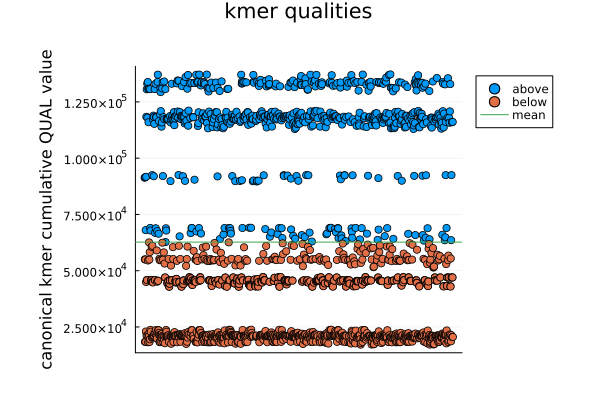

{1756, 1754} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [95]:
kmer_graph = build_directed_kmer_graph(fastq=assembly_fastq, k=assembly_k)

In [96]:
# load parameters onto the nodes and edges themselves

In [97]:
kmer_graph.gprops

Dict{Symbol, Any} with 15 entries:
  :state_likelihoods                  => OrderedDict{DNAKmer{379, 12}, Float64}…
  :ordered_kmers                      => DNAKmer{379, 12}[AAAAACGGAACCGCTTTGGCG…
  :branching_nodes                    => Set([551, 640, 1583])
  :kmer_counts                        => OrderedDict{DNAKmer{379, 12}, Int64}(A…
  :likely_sequencing_artifact_indices => [2, 3, 5, 6, 8, 9, 12, 14, 15, 18  …  …
  :total_states                       => 1756
  :canonical_kmer_indices             => OrderedDict{DNAKmer{379, 12}, Int64}(A…
  :kmer_mean_quality                  => OrderedDict{DNAKmer{379, 12}, Vector{F…
  :assembly_k                         => 379
  :canonical_kmer_counts              => OrderedDict{DNAKmer{379, 12}, Int64}(A…
  :unbranching_nodes                  => Set([1144, 1175, 719, 1546, 1703, 1028…
  :transition_likelihoods             => sparse([1332, 922, 923, 1, 2, 3, 1333,…
  :kmer_indices                       => OrderedDict{DNAKmer{379, 12}, Int64}(A…
 

In [98]:
kmer_graph

{1756, 1754} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [99]:
# likely_valid_subgraph, index_map = Graphs.induced_subgraph(kmer_graph, kmer_graph.gprops[:likely_valid_kmer_indices])

In [101]:
initial_connected_components = length(Graphs.connected_components(kmer_graph))

2

In [126]:
# heuristic - should be based on something better or removed altogether
max_filter = 5

initial_connected_components = length(Graphs.connected_components(kmer_graph))
coverage_threshold = 1
tresholded_vertices = [i for (i, (kmer, count)) in enumerate(MetaGraphs.get_prop(kmer_graph, :kmer_counts)) if count > coverage_threshold]
candidate_subgraph, vertex_map = Graphs.induced_subgraph(kmer_graph, tresholded_vertices)
while (length(Graphs.connected_components(candidate_subgraph)) == initial_connected_components) && (coverage_threshold < max_filter)
    coverage_threshold += 1
    tresholded_vertices = [i for (i, (kmer, count)) in enumerate(MetaGraphs.get_prop(kmer_graph, :kmer_counts)) if count > coverage_threshold]
    candidate_subgraph, vertex_map = Graphs.induced_subgraph(kmer_graph, tresholded_vertices)
end
coverage_threshold -= 1
@show coverage_threshold

tresholded_vertices = [i for (i, (kmer, count)) in enumerate(MetaGraphs.get_prop(kmer_graph, :kmer_counts)) if count > coverage_threshold]
filtered_graph, filtered_graph_vertex_map = Graphs.induced_subgraph(kmer_graph, tresholded_vertices)
# candidate_subgraph, vertex_map = Graphs.induced_subgraph(kmer_graph, [v for v in Graphs.vertices(kmer_graph) if kmer_graph.vprops[v][:count] >= coverage_threshold])

coverage_threshold = 3


({556, 554} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), [1, 4, 10, 11, 13, 16, 17, 19, 22, 23  …  1716, 1726, 1728, 1735, 1737, 1739, 1741, 1748, 1751, 1755])

In [156]:
connected_components = sort(Graphs.connected_components(filtered_graph), by=x->length(x), rev=true)
connected_component_sequences = BioSequences.LongDNA{2}[]
for connected_component in connected_components
    connected_component_subgraph, connected_component_subgraph_vertex_map = Graphs.induced_subgraph(filtered_graph, connected_component)
    sorted_connected_component_subgraph = Graphs.topological_sort_by_dfs(connected_component_subgraph)
    dsp_result = Graphs.dijkstra_shortest_paths(connected_component_subgraph, first(sorted_connected_component_subgraph))
    maxdist, maxdist_index = findmax(dsp_result.dists)
    connected_component_subgraph_longest_path = Graphs.enumerate_paths(dsp_result, maxdist_index)
    connected_component_subgraph_vertex_map
    original_graph_kmer_indices = filtered_graph_vertex_map[connected_component_subgraph_vertex_map[connected_component_subgraph_longest_path]]
    connected_component_subgraph_longest_path_reconstructed_sequence = Mycelia.kmer_path_to_sequence(kmer_graph.gprops[:ordered_kmers][original_graph_kmer_indices])
    push!(connected_component_sequences, connected_component_subgraph_longest_path_reconstructed_sequence)
end
connected_component_sequences

2-element Vector{BioSequences.LongSequence{BioSequences.DNAAlphabet{2}}}:
 AATATGGTGAAATCGAGTCCTCTTTGAGCGTTGAATGTG…ATCCGAATCTCTCGTACTGCAGCTCGTTAGATCCAACAC
 CCCACACTCCCCAGCTAAAAACGGAACCGCTTTGGCGTC…ATGCGGCAACCTCGGTCTCAAATATTCGTCATGTGAGAT

In [162]:
first_sequence_canonical_kmers = last.(collect(Kmers.EveryCanonicalKmer{Kmers.DNAKmer{assembly_k}}(connected_component_sequences[1])))

512-element Vector{Kmers.DNAKmer{379, 12}}:
 AATATGGTGAAATCGAGTCCTCTTTGAGCGTTGAATGTG…GTATTTCGTTACACACACAGTGTGCCCAATTACATCCCT
 ATATGGTGAAATCGAGTCCTCTTTGAGCGTTGAATGTGC…TATTTCGTTACACACACAGTGTGCCCAATTACATCCCTC
 GGAGGGATGTAATTGGGCACACTGTGTGTGTAACGAAAT…CGCACATTCAACGCTCAAAGAGGACTCGATTTCACCATA
 ATGGTGAAATCGAGTCCTCTTTGAGCGTTGAATGTGCGA…TTTCGTTACACACACAGTGTGCCCAATTACATCCCTCCA
 ATGGAGGGATGTAATTGGGCACACTGTGTGTGTAACGAA…ATCGCACATTCAACGCTCAAAGAGGACTCGATTTCACCA
 AATGGAGGGATGTAATTGGGCACACTGTGTGTGTAACGA…TATCGCACATTCAACGCTCAAAGAGGACTCGATTTCACC
 AAATGGAGGGATGTAATTGGGCACACTGTGTGTGTAACG…GTATCGCACATTCAACGCTCAAAGAGGACTCGATTTCAC
 AAAATGGAGGGATGTAATTGGGCACACTGTGTGTGTAAC…TGTATCGCACATTCAACGCTCAAAGAGGACTCGATTTCA
 AAAAATGGAGGGATGTAATTGGGCACACTGTGTGTGTAA…CTGTATCGCACATTCAACGCTCAAAGAGGACTCGATTTC
 AAATCGAGTCCTCTTTGAGCGTTGAATGTGCGATACAGG…TACACACACAGTGTGCCCAATTACATCCCTCCATTTTTC
 AATCGAGTCCTCTTTGAGCGTTGAATGTGCGATACAGGG…ACACACACAGTGTGCCCAATTACATCCCTCCATTTTTCT
 ATCGAGTCCTCTTTGAGCGTTGAATGTGCGATACAGGGC…CACACACAGTGTGCCCAATTACAT

In [163]:
second_sequence_canonical_kmers = last.(collect(Kmers.EveryCanonicalKmer{Kmers.DNAKmer{assembly_k}}(connected_component_sequences[2])))

44-element Vector{Kmers.DNAKmer{379, 12}}:
 AGTTCCCTCATACGCCGGATACAGTGCCGGTTACGCGTG…GACGCCAAAGCGGTTCCGTTTTTAGCTGGGGAGTGTGGG
 CCACACTCCCCAGCTAAAAACGGAACCGCTTTGGCGTCT…ACGCGTAACCGGCACTGTATCCGGCGTATGAGGGAACTA
 ATAGTTCCCTCATACGCCGGATACAGTGCCGGTTACGCG…GAGACGCCAAAGCGGTTCCGTTTTTAGCTGGGGAGTGTG
 AATAGTTCCCTCATACGCCGGATACAGTGCCGGTTACGC…TGAGACGCCAAAGCGGTTCCGTTTTTAGCTGGGGAGTGT
 CAATAGTTCCCTCATACGCCGGATACAGTGCCGGTTACG…TTGAGACGCCAAAGCGGTTCCGTTTTTAGCTGGGGAGTG
 ACTCCCCAGCTAAAAACGGAACCGCTTTGGCGTCTCAAT…GTAACCGGCACTGTATCCGGCGTATGAGGGAACTATTGA
 ATCAATAGTTCCCTCATACGCCGGATACAGTGCCGGTTA…CATTGAGACGCCAAAGCGGTTCCGTTTTTAGCTGGGGAG
 CATCAATAGTTCCCTCATACGCCGGATACAGTGCCGGTT…GCATTGAGACGCCAAAGCGGTTCCGTTTTTAGCTGGGGA
 CCCCAGCTAAAAACGGAACCGCTTTGGCGTCTCAATGCG…ACCGGCACTGTATCCGGCGTATGAGGGAACTATTGATGC
 CCCAGCTAAAAACGGAACCGCTTTGGCGTCTCAATGCGC…CCGGCACTGTATCCGGCGTATGAGGGAACTATTGATGCG
 CCAGCTAAAAACGGAACCGCTTTGGCGTCTCAATGCGCG…CGGCACTGTATCCGGCGTATGAGGGAACTATTGATGCGG
 CAGCTAAAAACGGAACCGCTTTGGCGTCTCAATGCGCGC…GGCACTGTATCCGGCGTATGAGGGA

In [165]:
intersect(first_sequence_canonical_kmers, second_sequence_canonical_kmers)

Kmers.DNAKmer{379, 12}[]

In [166]:
sequence = first(connected_component_sequences)

890nt DNA Sequence:
AATATGGTGAAATCGAGTCCTCTTTGAGCGTTGAATGTG…ATCCGAATCTCTCGTACTGCAGCTCGTTAGATCCAACAC

In [169]:
assembly_fasta = replace(assembly_fastq, Mycelia.FASTQ_REGEX => ".assembly_k$(assembly_k).fna")

"/global/cfs/cdirs/m4269/cjprybol/Mycelia/projects/variant-calling-benchmarking/data/genomes/fF3EHHs.fna.normalized.vcf.fna.badread.10x.filtlong.k11.k13.k17.k19.k23.k31.k53.k89.assembly_k379.fna"

In [171]:
open(assembly_fasta, "w") do io
    fastx_io = FASTX.FASTA.Writer(io)
    for (i, sequence) in enumerate(connected_component_sequences)
        identifier = "contig$(i)_length=$(length(sequence))"
        fasta_record = FASTX.FASTA.Record(identifier, sequence)
        write(fastx_io, fasta_record)
    end
    close(fastx_io)
end

In [172]:
readlines(assembly_fasta)

22-element Vector{String}:
 ">contig1_length=890"
 "AATATGGTGAAATCGAGTCCTCTTTGAGCGTTGAATGTGCGATACAGGGCATAAAGGTACTAAAGCAGAG"
 "TGACCCCTGCCCTATATCAAAGAACAAATATGCGTGGACGCCTCTTGGATAATCTCAGTGCCATCCCAGG"
 "GACCTACCCTCTTTACTGAGAAGTATAGGCCAGACATGCTCCAACTCAAATCCTTGGGCAATACACCGCG"
 "ACCCTCTACTGCATCTCACATGACGAATATTTGAGACCGAGGTTGCCGCATCAATAGTTCCCTCGTCATA"
 "CGCCGGATACAGTGCCGGTTACGCGTGCCGAACGATCGTTCGACCCACACGTGTGCCAATGTATTTCGTT"
 "ACACACACAGTGTGCCCAATTACATCCCTCCATTTTTCTCGTGTATTGATGTCGAATCCTATTCTATATG"
 "AGGGTTCTATTCCTACACTCGCGATCGATGGGAACGAGCAAAGCCTCGAAACTAAGCGGACATTTACGCT"
 "TCATACCACACTGTTCTATAGGTTAGACCAGCGATTTGTCCAAACCATAGCGCCAAGGTAGCAGAATCGA"
 "CTTGCTTCGCCTTGTTTAGGCCCAATGCTACTGCTTGTTGGCGCGTATCTCTGAGACGCCAAAGCGGTTC"
 "CGTTTTTACATGGGGAGTGTGGGGTCTCTTCTCGGATGGTGTACCGATACTTAGCTAATATCCGGACTGT"
 "TGATCTTTCACGTGTTAAGCTCTCCGGCTCCACGACCCAGGTTCATCCCATGGATCAATGGGCGTGTCCC"
 "CAATGGCTACGTGTGTGCGGACGCTCCATGGGTGCTCGCGGACTCTGCGAAAAACAATTGACTTGACTGC"
 "TCGAGCTCAGTATCCGAATCTCTCGTACTGCAGCTCGTTAGATCCAACAC"
 ">conti